<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://snap.stanford.edu/data/loc-gowalla.html

In [0]:
!wget https://snap.stanford.edu/data/loc-gowalla_edges.txt.gz
!gunzip loc-gowalla_edges.txt.gz

In [0]:
#Preprocess
import numpy as np
from collections import defaultdict

edges = []
neighbours = defaultdict(list)

with open('loc-gowalla_edges.txt', 'r') as f:
    for line in f.readlines():
        line = line[:-1]
        a,b = map(int, line.split('\t'))
        
        edges.append((a,b))
        neighbours[a].append(b)

for a in neighbours.keys():
    edges.append((a,a))

# Affinity propagation

In [0]:
# Define Similarity, Availability, Responsibility matrices

n = 196591
e = 950327*2

S = np.ones(n + e, dtype=float)   #0..e - similarity 
S[e:] = np.full(n, 0.5)           #e..n+e - self-similarity

A = np.zeros_like(S)
R = np.zeros_like(S)

smoothing=0.5

In [66]:
from tqdm import trange

exemplars = np.array([])

iters = 5
for iter in trange(iters):
    #Responsibility
    tmp = A.copy()
    tmp += S  #A + S

    # max_{k'!=k} (a(i,k') + s(i,k'))
    M1 = np.full(n, -np.inf)  #max tmp
    M2 = np.full(n, -np.inf)  #second max (for k==argmax)
    I = np.full(n, -1)        #argmax tmp
    for i, (a,b) in enumerate(edges):   #Diag?
        if M1[a] <= S[i]:
            M2[a] = M1[a]
            M1[a] = S[i]
            I[a] = b
        elif M2[a] <= S[i]:
            M2[a] = S[i]

    # R = S - max{...}
    R_new = S.copy()
    for i, (a,b) in enumerate(edges):
        R_new[i] -= M2[a] if b==I[a] else M1[a]
    
    R = smoothing * R + (1 - smoothing) * R_new

    #Availability
    tmp = R.copy()
    tmp[:e] = np.maximum(0, tmp[:e])    #... max(0, r(i',k)) for non-diag
                                        # r(k,k) are untouched
    sum_tmp = np.zeros(n) 
    for i, (a,b) in enumerate(edges):
        sum_tmp[b] += tmp[i]
    
    A_new = np.zeros_like(A)
    for i, (a,b) in enumerate(edges):
        A_new[i] = sum_tmp[b] - tmp[i]

    A_new[:e] = np.minimum(0, A_new[:e])    # min(0, ...) for non-diag

    A = smoothing * A + (1 - smoothing) * A_new

    #Check for convergance
    exemplars_old = exemplars.copy()
    exemplars = np.where(A[e:] + R[e:] > 0)[0]

if (exemplars_old == exemplars).all():
    print('\nconverged')

100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


converged


In [241]:
print("Found %d exemplars" % len(exemplars))

Found 7710 exemplars


### Find corresponding exemplar for each node

In [69]:
#Assign immediate neightbours to exemplars
M = np.full(n, -np.inf)
I = np.full(n, -1)
for i, (a,b) in enumerate(edges):
    if b in exemplars and M[a] <= S[i]:
        M[a] = S[i]
        I[a] = b
I

array([   608,   1403,   2434, ..., 196540,     -1,     -1])

In [72]:
#Set identity exemplars
for i in exemplars:
    I[i] = i
    M[i] = 1

I

array([     0,      1,      2, ..., 196540,     -1,     -1])

In [73]:
#For unassigned nodes, set label(i)=argmax_j(A_ij+R_ij) 
Cr = A+R
for i, (a,b) in enumerate(edges):
    if I[a] == -1 and M[a] < Cr[i]:
        M[a] = Cr[i]
        I[a] = b
I

array([     0,      1,      2, ..., 196540, 196547, 196561])

In [99]:
#Transitively collapse labels to exemplars
while True:
    new_I = I.copy()
    for i, label in enumerate(new_I):
        if label not in exemplars:      #FIXME there was M[i] < 0 first, not sure if its deletion will break stuff
            new_I[i] = new_I[label]

    if (I == new_I).all():
        break

    I = new_I
new_I

array([     0,      1,      2, ..., 196540,  59777,   7148])

In [100]:
len(np.unique(new_I))

7710

In [0]:
labels = new_I

# Analize clusters

Populating the interactive namespace from numpy and matplotlib


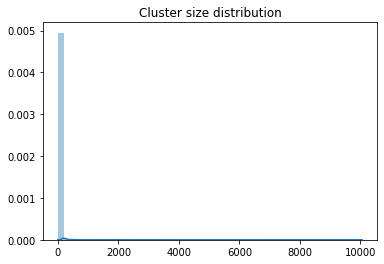

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

cluster_sizes = defaultdict(int)

for label in labels:
    cluster_sizes[label] += 1

sizes = sorted(cluster_sizes.values(), reverse=True)

plt.title("Cluster size distribution")
sns.distplot(sizes)

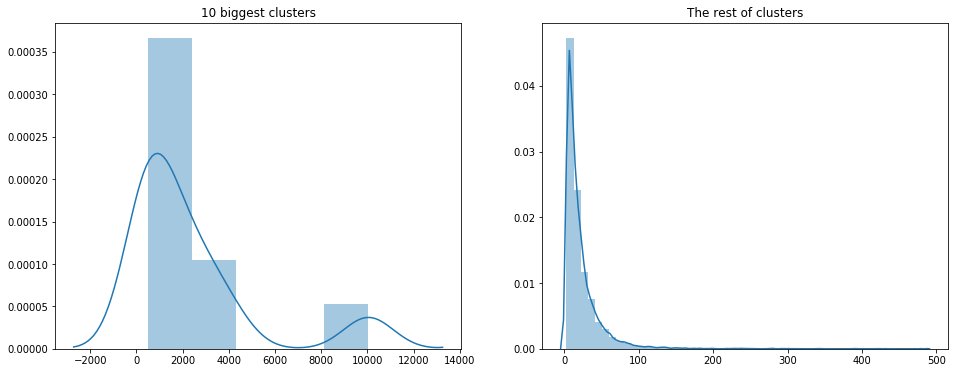

Max cluster size: 10050, min cluster size: 3


In [260]:
plt.figure(figsize=(16,6))

ax = plt.subplot(1, 2, 1)
ax.set_title("10 biggest clusters")
sns.distplot(sizes[:10])

ax = plt.subplot(1, 2, 2)
ax.set_title("The rest of clusters")
sns.distplot(sizes[10:])
plt.show()
print("Max cluster size: %d, min cluster size: %d" % (sizes[0], sizes[-1]))

# Train top-k classifier

In [0]:
!wget https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz
!gunzip loc-gowalla_totalCheckins.txt.gz

In [0]:
checkins = []

with open('loc-gowalla_totalCheckins.txt', 'r') as f:
    for line in f.readlines():
        line = line[:-1]
        line = line.split('\t')
        user, loc = int(line[0]), int(line[-1])
        checkins.append((user, loc))

In [0]:
checkins_by_user = defaultdict(list)

for (user, loc) in checkins:
    checkins_by_user[user].append(loc)

In [263]:
# Train test split

np.random.seed(0)

users = list(set(checkins_by_user.keys()))
users = np.array(users)
np.random.shuffle(users)

train_test_split = 0.1
split_ind = int(train_test_split*len(users))

users_train, users_test = users[split_ind:], users[:split_ind]
print("Users in train set: %d, users in test set: %d" % (len(users_train), len(users_test)))

Users in train set: 96383, users in test set: 10709


In [0]:
locations = np.array(list(set([x[1] for x in checkins])))
n_locations = len(locations)

loc_to_ind = {x:i for i,x in enumerate(locations)}

### Baseline classifier

In [266]:
k = 10

# Train
checkin_count = np.zeros_like(locations)
for user in users_train:
    for loc in checkins_by_user[user]:
        checkin_count[loc_to_ind[loc]] += 1

topk_ind = np.argpartition(checkin_count, -k)[-k:]
topk_ind = topk_ind[np.argsort(checkin_count[topk_ind])]

topk_recommended_locations = locations[topk_ind[::-1]]
print("Top-10 locations: ", topk_recommended_locations)
print("Check-ins count: ", checkin_count[topk_ind[::-1]])

Top-10 locations:  [55033 19542  9410 10259 58725 14470 10190  9246 23256  9241]
Check-ins count:  [5154 5003 4234 3775 3146 3093 3076 3045 3025 2992]


In [175]:
# Test
precision_at_k = 0

for user in users_test:
    relevant = 0
    for loc in topk_recommended_locations:
        if loc in checkins_by_user[user]:
            relevant += 1
    precision_at_k += relevant/k

precision_at_k /= len(users_test)
print("Mean precision@10 = ", precision_at_k)

Mean precision@10 =  0.01757400317489932


### Top-k classifier for each cluster

In [0]:
# Train
n_clusters = len(exemplars)
topk_by_cluster = np.zeros((n_clusters, 10))

users_by_cluster = defaultdict(list)
for user in users_train:
    cluster = labels[user]
    users_by_cluster[cluster].append(user)

clust_to_ind = {x:i for i,x in enumerate(exemplars)}

In [0]:
# For each cluster find top-10 locations
for cluster, users_in_cluster in users_by_cluster.items():
    checkin_count = np.zeros_like(locations)

    for user in users_in_cluster:
        for loc in checkins_by_user[user]:
            checkin_count[loc_to_ind[loc]] += 1

    topk_ind = np.argpartition(checkin_count, -k)[-k:]
    topk_ind = topk_ind[np.argsort(checkin_count[topk_ind])]
    topk_locations = locations[topk_ind[::-1]]

    if len(topk_locations)<k:
        empty_topk = np.full(k,-1)
        empty_topk[:len(topk_locations)] = topk_locations
        topk_locations = empty_topk
    
    topk_by_cluster[clust_to_ind[cluster]] = topk_locations

In [239]:
#Test
precision_at_k = 0

for user in users_test:
    relevant = 0

    label = labels[user]
    cluster_ind = clust_to_ind[label]

    for loc in topk_by_cluster[cluster_ind]:
        if loc in checkins_by_user[user]:
            relevant += 1
    precision_at_k += relevant/k

precision_at_k /= len(users_test)
print("Mean precision@10 = ", precision_at_k)

Mean precision@10 =  0.03437295732561423
